# Findings

## Purpose

The purpose of this project is to analyze NYC vehicle collisions data, and to extract insights that may benefit the general public. 

This dataset includes data from 2012-07-01 to 2022-1-24.

## Results


1. We see number of collisions decreasen siginificantly during 2020. This is likely due to the COVID-19 qurantine.

2. **Manhatthan is the most dangerous borough for drivers**. For the last 10 years, Manhattan has almost 13,000 collisions per square mile. This is 116% more collisions per square mile than the 2nd place Brooklyn, with 6,000 collisions per square mile. 


3. Within Manhatthan, **lower Manhatthan is the most dangerous area**. Some parts of lower Manhatthan can see up to 1000 collisions per sq mile per year, almost 3 collisions a day per sq mile.

The following picture demonstrates the 2022 collision cases. 


![title](images\map.png)


**NYPD do not record crashes in some areas, hence the black-shaded areas.**



## Date source: 

https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

# Import library and data

In [1]:
# DS
import pandas as pd
import numpy as np


# Visualizations
import folium 
from matplotlib import pyplot as plt


# Other
import warnings
import json


warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
download_url = 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD'

In [6]:
# Downloading the file may take 2 mins...
df = pd.read_csv(download_url)

# Basic Data Exploration

In [10]:
len(df)

1967681

In [11]:
# Explore the data
df.isnull().sum()

CRASH DATE                             0
CRASH TIME                             0
BOROUGH                           611557
ZIP CODE                          611793
LATITUDE                          225751
LONGITUDE                         225751
LOCATION                          225751
ON STREET NAME                    410637
CROSS STREET NAME                 729104
OFF STREET NAME                  1649415
NUMBER OF PERSONS INJURED             18
NUMBER OF PERSONS KILLED              31
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       6061
CONTRIBUTING FACTOR VEHICLE 2     296704
CONTRIBUTING FACTOR VEHICLE 3    1829323
CONTRIBUTING FACTOR VEHICLE 4    1936835
CONTRIBUTING FACTOR VEHICLE 5    1959398
COLLISION_ID                           0
VEHICLE TYPE COD

In [12]:
# drop any nulls that exist in latitude & longitude
print(f'the len of df is {len(df)} before dropping nulls')
df = df.dropna(subset = ['LATITUDE','LONGITUDE'])
print(f'the len of df is {len(df)} after dropping nulls')

the len of df is 1967681 before dropping nulls
the len of df is 1741930 after dropping nulls


In [13]:
# Are there wrong data? Let's get rid of them.
lat_value_counts = df['LATITUDE'].value_counts()
display(lat_value_counts.sort_index())

# Are there wrong data? Let's get rid of them.
long_value_counts = df['LONGITUDE'].value_counts()
display(long_value_counts.sort_index())

# From prior knowledge, I know that NYC geo data should exist somewhere in the (40s, -70s)
# We can further validate the data by plotting the data points on folium
df = df[df['LATITUDE'].between(40.498949, 43.344444)]
df = df[df['LONGITUDE'].between(-79.619550, -73.663010)]

0.000000     4100
30.784180       1
34.783634       1
40.498949       2
40.499135       1
             ... 
41.916610       1
42.107204       1
42.318317       1
42.641540       1
43.344444       1
Name: LATITUDE, Length: 124867, dtype: int64

-201.359990       1
-201.237060     105
-89.135270        1
-86.768470        1
-79.619550        1
               ... 
-73.700550        2
-73.663010        1
-47.209625        3
-32.768513       16
 0.000000      4100
Name: LONGITUDE, Length: 97339, dtype: int64

In [14]:
# convert dates to years
df['date'] = pd.to_datetime(df['CRASH DATE'])
df['year'] = df['date'].apply(lambda x:x.year)

# See data date range
df.groupby('BOROUGH')['date'].agg({'min','max'})

,min,max
BOROUGH,,
BRONX,2012-07-01,2023-02-07
BROOKLYN,2012-07-01,2023-02-07
MANHATTAN,2012-07-01,2023-02-07
QUEENS,2012-07-01,2023-02-07
STATEN ISLAND,2012-07-01,2023-02-07


In [15]:
len(df)

1737701

# How does the automobile collision counts differ yearly in each NYC borough?

---
We observed two notable trends in NYC's vehicle collisions from 2012 to 2022:

1. We see a moderate decline in vehicle collisions from 2015 to 2016.
2. We see a steep decline in vehicle collisions from 2019 to 2020. This is most likely caused by the COVID-19 qurantine.

In [16]:
# create dataframe for yearly collisions
df_yearly_collisions = df.groupby(['BOROUGH'])['year'].value_counts().to_frame()
df_yearly_collisions = df_yearly_collisions.rename(columns = {df.year.name : 'num_collisions'})
df_yearly_collisions = df_yearly_collisions.reset_index()
df_yearly_collisions = df_yearly_collisions.sort_values(by = ['BOROUGH','year'])

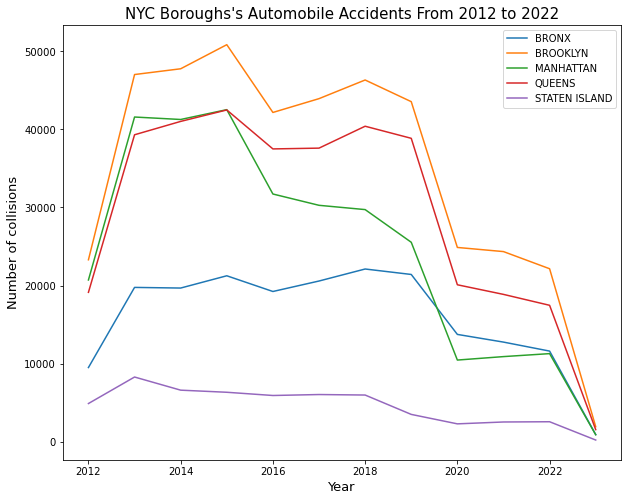

In [17]:
# Create an empty figure
plt.figure(figsize=(10, 8))

# create a data frame for each borough's yearly accidents
for borough in df_yearly_collisions['BOROUGH'].unique():
    df_borough_yearly = df_yearly_collisions[df_yearly_collisions['BOROUGH'] == borough]
    plt.plot(df_borough_yearly['year'],
             df_borough_yearly['num_collisions'],
             label=borough)

# Create labels & titles
plt.title('NYC Boroughs\'s Automobile Accidents From 2012 to 2022',
          fontsize=15)
plt.ylabel('Number of collisions', fontsize=13)
plt.xlabel('Year', fontsize=13)
plt.legend(loc="upper right")
plt.show()

# What is the most dangerous borough?

Which borough are we most likely to get into a collsion?

---
Given Manhatthan's large population density and popularity, it only makes sense for it to be the most dangerous borough. 

For the last 10 years, Manhattan has almost 13,000 collisions per square mile. This is 116% more collisions per square mile than the 2nd place Brooklyn, with 6,000 collisions per square mile.


Note that a better area estimate would be road area instead of total borough area. It's possible that some boroughs have more streets than other boroughs. 

In [18]:
# create a df for boroughs
df_boroughs = df['BOROUGH'].value_counts().to_frame()
df_boroughs = df_boroughs.reset_index()
df_boroughs.columns = ['boroughs', 'num_collisions']

# create a dict linking boroughs to their land area in mile^2
boroughs2area = {
    'MANHATTAN': 22.82,
    'BROOKLYN': 69.5,
    'QUEENS': 108.1,
    'BRONX': 42.47,
    'STATEN ISLAND': 58.69
}

# map each borough to its respective borough
df_boroughs['area'] = df_boroughs['boroughs'].map(boroughs2area)
df_boroughs['collisions_per_mi^2'] = df_boroughs[
    'num_collisions'] / df_boroughs['area']
df_boroughs

,boroughs,num_collisions,area,collisions_per_mi^2
0,BROOKLYN,418224,69.50,6017.611511
1,QUEENS,354327,108.10,3277.770583
2,MANHATTAN,296941,22.82,13012.313760
3,BRONX,192661,42.47,4536.402166
4,STATEN ISLAND,55268,58.69,941.693645


# What are the most dangerous zipcodes?

Let's only look at recent data for relevancy.
If we want to avoid getting into car crashes, which neighborhoods should we avoid driving in?

According to the data, lower manhatthan seems to be the most dangerous area to be driving in. Especially the zones near the bridges.

This shouldn't come as a surprise, since lower manhatthan has some of the most popular neighborhoods in NYC.

The top 5 most dangerous zip codes are (10036, 10018, 10022, 10016, 10013). 	

![title](images\map.png)

In [19]:
# load GeoJSON & Exploring it
with open('data\\nyc.geojson', 'r') as jsonFile:
    geo_data = json.load(jsonFile)
geo_data

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': 0,
   'properties': {'OBJECTID': 1,
    'postalCode': '11372',
    'PO_NAME': 'Jackson Heights',
    'STATE': 'NY',
    'borough': 'Queens',
    'ST_FIPS': '36',
    'CTY_FIPS': '081',
    'BLDGpostalCode': 0,
    'Shape_Leng': 20624.6923165,
    'Shape_Area': 20163283.8744,
    '@id': 'http://nyc.pediacities.com/Resource/PostalCode/11372'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-73.86942457284175, 40.74915687096787],
      [-73.89507143240856, 40.74646547081214],
      [-73.89618737867819, 40.74850942518086],
      [-73.89583954185139, 40.748546875706005],
      [-73.89525242774396, 40.74830660945023],
      [-73.89654041085561, 40.750541998143575],
      [-73.89579868613828, 40.750619721332605],
      [-73.89652230661433, 40.75438879610902],
      [-73.87221855882477, 40.756943248067465],
      [-73.87167992356791, 40.75398717439602],
      [-73.87207046513889, 40.75386200705204],
      [-73.8

In [20]:
# Read Zip code area data
df_zip_2_area = pd.read_excel('data\\zip_area.xlsx')
df_zip_2_area.head(2)

,zipcode,area sq mile
0,10001,0.621393
1,10002,0.879413


In [21]:
# clean data
df = df[df['ZIP CODE'] != '     ']
df = df[~df['ZIP CODE'].isnull()]
df['ZIP CODE'] = df['ZIP CODE'].apply(lambda x: int(x))

# Let's only look at recent data
df_2022 = df[df['year'] == 2022]
df_2022.head(2)

# create a df for zip codes
df_zipcode = df_2022.groupby('ZIP CODE')['COLLISION_ID'].nunique().to_frame()
df_zipcode = df_zipcode.reset_index()
df_zipcode = df_zipcode.merge(df_zip_2_area,
                              how='left',
                              left_on='ZIP CODE',
                              right_on='zipcode')
df_zipcode

,ZIP CODE,COLLISION_ID,zipcode,area sq mile
0,10000,29,NaN,NaN
1,10001,497,10001.0,0.621393
2,10002,698,10002.0,0.879413
3,10003,325,10003.0,0.576451
4,10004,67,10004.0,0.559748
...,...,...,...,...
205,11692,115,11692.0,0.998622
206,11693,90,11693.0,0.997147
207,11694,92,11694.0,1.365643
208,11695,1,NaN,NaN


There are a few zip codes that have few info about them online, such as 10000.

They are all fairly small & have few crashes. Let's ignore them.

In [22]:
df_zipcode = df_zipcode[~df_zipcode['area sq mile'].isnull()]
df_zipcode['collision_per_sq_mile'] = df_zipcode['COLLISION_ID'] / df_zipcode['area sq mile']

# Also, let's only look at zip code > 0.2 sq mile
df_zipcode = df_zipcode[df_zipcode['area sq mile'] > 0.1]
df_zipcode.sort_values(by='collision_per_sq_mile', ascending=False)

,ZIP CODE,COLLISION_ID,zipcode,area sq mile,collision_per_sq_mile
34,10036,443,10036.0,0.443288,999.350875
16,10018,316,10018.0,0.321774,982.054355
20,10022,419,10022.0,0.436373,960.188478
14,10016,484,10016.0,0.532176,909.473236
12,10013,473,10013.0,0.552296,856.424860
...,...,...,...,...,...
81,10314,107,10314.0,13.714619,7.801894
72,10302,7,10302.0,1.194380,5.860781
209,11697,8,11697.0,2.219806,3.603919
110,11040,17,11040.0,4.783188,3.554115


In [23]:
nyc_geo = 'data\\nyc.geojson'

m = folium.Map(location=[40.719025, -73.989780], zoom_start=11)
m.choropleth(
    geo_data=nyc_geo,
    fill_opacity=0.8,
    line_opacity=1,
    data=df_zipcode,
    columns=['ZIP CODE', 'collision_per_sq_mile'],
    key_on=
    'feature.properties.postalCode',  # key_on => key mapping geojson to zip code
    fill_color="YlOrRd")

folium.LayerControl().add_to(m)
m.save(outfile='images\\map.html')
m

# Why do we not see data for some areas?


NYPD do not record collisions in some areas such as the LGA airport. They also redistributed some crashes from central park to nearby zipcodes.

In [24]:
# Why are some areas not colored?
all_zipcodes =set(df_zip_2_area['zipcode'])
police_records_zip = set(df_zipcode['zipcode'])

# Either these areas' zip code were updated
# Or the police did not record crashes in these areas:
    # Roosevelt island, LGA airport...etc
c = all_zipcodes.difference(police_records_zip)
c

{10005,
 10006,
 10020,
 10044,
 10103,
 10110,
 10111,
 10112,
 10115,
 10119,
 10152,
 10153,
 10154,
 10162,
 10165,
 10167,
 10168,
 10169,
 10170,
 10171,
 10172,
 10173,
 10174,
 10177,
 10199,
 10271,
 10278,
 10279,
 10282,
 10303,
 10311,
 11003,
 11109,
 11351,
 11371,
 11424,
 11425,
 11451}

In [ ]:
# Let's confirm our suspicisions
# NYPD do not record collisions in those areas

# sample of our entire data
df_sample = df_2022.sample(frac=0.1, random_state=42)
location_list = list(zip(df_sample['LATITUDE'], df_sample['LONGITUDE']))

# declare geojson file path
nyc_geo = 'data\\nyc.geojson'

# create map
m = folium.Map(location=[40.719025, -73.989780], zoom_start=11)

# color grade the 2022 NYC dangerous zip codes
m.choropleth(
    geo_data=nyc_geo,
    fill_opacity=0.5,
    line_opacity=1,
    data=df_zipcode,
    columns=['ZIP CODE', 'collision_per_sq_mile'],
    key_on=
    'feature.properties.postalCode',  # key_on => key mapping geojson to zip code
    fill_color="YlOrRd")

# randomly plot 3000 accident point
for point in range(0, len(df_sample)):
    folium.CircleMarker(location_list[point],
                        radius=1,
                        color='red',
                        fill=True,
                        fill_color='red',
                        opacity=0.5).add_to(m)

folium.LayerControl().add_to(m)

m

We can see our suspicisions are correct. NYPD do not record collisions into their official data (OR the crash data from those area is withheld from public).